# Luxury Beauty Product Recommendation System
This project applies **collaborative filtering methods** on the Amazon Luxury Beauty dataset (~574k reviews, ~12k products) to build a recommendation system.  
The focus is on comparing baseline and advanced approaches to evaluate their ability to capture user preferences.

## Models
- **Popularity Baseline** — global top-rated products  
- **Item-based CF** — product–product similarity  
- **User-based CF** — neighbor-based recommendations  
- **Matrix Factorization (TruncatedSVD)** — latent factor modeling  

## Goal
To assess how different recommendation techniques perform in terms of personalization and predictive power, highlighting trade-offs between simplicity, scalability, and accuracy.

### Setup & Load

In [1]:
# Setup & Load
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_json(
   "../data/Luxury_Beauty.json.gz",
    lines=True,
    compression="gzip"
)

print(df.shape)
df.head()

(574628, 12)


,overall,vote,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,style,image
0,2,3,True,"06 15, 2010",A1Q6MUU0B2ZDQG,B00004U9V2,D. Poston,"I bought two of these 8.5 fl oz hand cream, an...",dispensers don't work,1276560000,NaN,NaN
1,5,14,True,"01 7, 2010",A3HO2SQDCZIE9S,B00004U9V2,chandra,"Believe me, over the years I have tried many, ...",Best hand cream ever.,1262822400,NaN,NaN
2,5,NaN,True,"04 18, 2018",A2EM03F99X3RJZ,B00004U9V2,Maureen G,Great hand lotion,Five Stars,1524009600,{'Size:': ' 3.5 oz.'},NaN
3,5,NaN,True,"04 18, 2018",A3Z74TDRGD0HU,B00004U9V2,Terry K,This is the best for the severely dry skin on ...,Five Stars,1524009600,{'Size:': ' 3.5 oz.'},NaN
4,5,NaN,True,"04 17, 2018",A2UXFNW9RTL4VM,B00004U9V2,Patricia Wood,The best non- oily hand cream ever. It heals o...,I always have a backup ready.,1523923200,{'Size:': ' 3.5 oz.'},NaN


**Analysis:** Data loads correctly (rows × columns match the printed shape). Core fields `reviewerID`, `asin`, and `overall` are present for recommender modeling.

### Missing Values

In [2]:
# Missing values
df.isna().sum()

# Unique users/products
n_users = df['reviewerID'].nunique()
n_items = df['asin'].nunique()
print("Unique users:", n_users)
print("Unique products:", n_items)

Unique users: 416174
Unique products: 12120


**Analysis:** Ratings (`overall`) have no missing values. Other optional fields (e.g., vote, style, image) are sparse but not needed for collaborative filtering. ~416k users and ~12k products confirm a highly sparse user–item matrix.

In [3]:
# Helper: Percent Labels
import matplotlib.pyplot as plt

def add_percentages():
    ax = plt.gca()
    total = sum([p.get_height() for p in ax.patches]) or 1
    for p in ax.patches:
        height = p.get_height()
        pct = (height / total) * 100
        ax.text(p.get_x() + p.get_width()/2., height, f"{pct:.1f}%",
                ha="center", va="bottom", fontsize=9)

**Analysis:** Helper function to annotate bar charts with percentage labels.

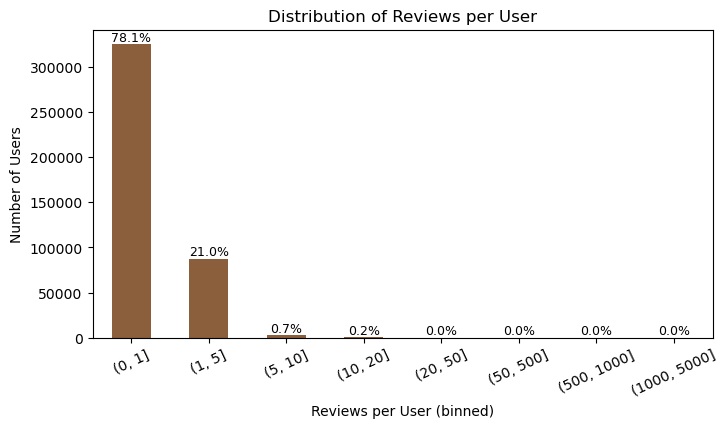

In [4]:
# Users: Reviews per User
user_bins = pd.cut(
    df['reviewerID'].value_counts(),
    bins=[0,1,5,10,20,50,500,1000,5000]
)

user_bins.value_counts().sort_index().plot(kind="bar", color="#8B5E3C", figsize=(8,4))
plt.title("Distribution of Reviews per User")
plt.xlabel("Reviews per User (binned)")
plt.ylabel("Number of Users")
plt.xticks(rotation=25)
add_percentages()
plt.show()

**Analysis:** Most users contribute very few reviews (1–5). A long tail of highly active users reflects typical recommender system sparsity.

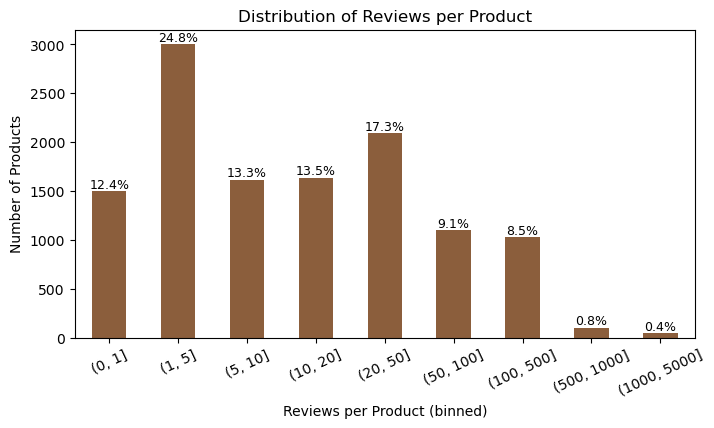

In [5]:
# Products: Reviews per Product
item_bins = pd.cut(
    df['asin'].value_counts(),
    bins=[0,1,5,10,20,50,100,500,1000,5000]
)

item_bins.value_counts().sort_index().plot(kind="bar", color="#8B5E3C", figsize=(8,4))
plt.title("Distribution of Reviews per Product")
plt.xlabel("Reviews per Product (binned)")
plt.ylabel("Number of Products")
plt.xticks(rotation=25)
add_percentages()
plt.show()

**Analysis:** Most products receive few reviews, while a small set dominates activity — the standard “long tail” in e-commerce.

In [6]:
# User–Item Ratings & 5-Core

df_small = df[['reviewerID', 'asin', 'overall']].rename(
    columns={'reviewerID': 'user_id', 'asin':'item_id', 'overall': 'rating'}
)

print("Rows:", len(df_small))
print("Unique users:", df_small['user_id'].nunique())
print("Unique items:", df_small['item_id'].nunique())
df_small.head()

Rows: 574628
Unique users: 416174
Unique items: 12120


,user_id,item_id,rating
0,A1Q6MUU0B2ZDQG,B00004U9V2,2
1,A3HO2SQDCZIE9S,B00004U9V2,5
2,A2EM03F99X3RJZ,B00004U9V2,5
3,A3Z74TDRGD0HU,B00004U9V2,5
4,A2UXFNW9RTL4VM,B00004U9V2,5


In [7]:
#  5-Core Filter & Pivot

u_cnt = df_small['user_id'].value_counts()
i_cnt = df_small['item_id'].value_counts()

core = df_small[
    df_small['user_id'].isin(u_cnt[u_cnt >= 5].index) &
    df_small['item_id'].isin(i_cnt[i_cnt >= 5].index)
].copy()

print("Original:", df_small.shape, "| 5-core:", core.shape)
core.head()

Original: (574628, 3) | 5-core: (49547, 3)


,user_id,item_id,rating
51,AWCX1MPM94R1A,B00004U9V2,5
70,A2HOI48JK8838M,B00004U9V2,5
128,AZY31SPDXGJQ,B00004U9V2,5
147,A2NB16B6V1DXL,B00004U9V2,5
148,A2NB16B6V1DXL,B00004U9V2,5


**Analysis:** Filtering to users/items with ≥5 ratings reduces sparsity and improves reliability of similarity estimates.

In [8]:
# User–Item Matrix
user_item_matrix = core.pivot_table(
    index="user_id",
    columns="item_id",
    values="rating"
).fillna(0)

print("Matrix shape:", user_item_matrix.shape)
user_item_matrix.iloc[:5, :5]

Matrix shape: (6107, 5514)


item_id,B00004U9V2,B0000532JH,B00005NDTD,B00005R7ZY,B00005V50B
user_id,,,,,
A0067293ETUPO6WG7DKU,0.0,0.0,0.0,0.0,0.0
A0488385844WNV2OWO9X,0.0,0.0,0.0,0.0,0.0
A0505999GY3IIQK03WD1,0.0,0.0,0.0,0.0,0.0
A0511945GWBL7PD6FC9N,0.0,0.0,0.0,0.0,0.0
A0916357J9P21ZUYUZO6,0.0,0.0,0.0,0.0,0.0


**Analysis:** The sparse pivot matrix enables similarity and factorization methods.

In [9]:
# Popularity Stats
item_stats = (
    df_small
    .groupby('item_id')['rating']
    .agg(count='count', mean='mean')
    .reset_index()
)

top_items = (
    item_stats[item_stats['count'] >= 50]
    .sort_values(['mean', 'count'], ascending=[False, False])
)

top_items.round({'mean':3})

,item_id,count,mean
6589,B00EMCGTAW,67,4.940
2198,B001F7J8RI,68,4.912
1379,B000VIZEOS,110,4.891
1450,B000WT9VTA,82,4.878
2570,B001QN3836,78,4.872
...,...,...,...
11911,B01EXAC212,75,2.867
443,B000BBGS1S,95,2.811
520,B000C9M0UW,95,2.811
11888,B01ESD5ACM,81,2.704


**Analysis:** Provides a global popularity baseline by ranking items with many high ratings.

In [10]:
# Item-Based CF: Similarity & Split

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

# Train/test split on 5-core
train_df, test_df = train_test_split(core, test_size=0.2, random_state=42)
print("Train:", train_df.shape, "Test:", test_df.shape)

# Train matrix & item similarity
train_matrix = train_df.pivot_table(
    index='user_id', columns='item_id', values='rating'
).fillna(0)

item_matrix = train_matrix.T
item_similarity = cosine_similarity(item_matrix)
import pandas as pd
item_sim_df = pd.DataFrame(item_similarity, index=item_matrix.index, columns=item_matrix.index)
item_sim_df.iloc[:5, :5]

Train: (39637, 3) Test: (9910, 3)


item_id,B00004U9V2,B0000532JH,B00005NDTD,B00005R7ZY,B00005V50B
item_id,,,,,
B00004U9V2,1.0,0.000000,0.0,0.000000,0.0
B0000532JH,0.0,1.000000,0.0,0.780869,0.0
B00005NDTD,0.0,0.000000,1.0,0.000000,0.0
B00005R7ZY,0.0,0.780869,0.0,1.000000,0.0
B00005V50B,0.0,0.000000,0.0,0.000000,1.0


**Analysis:** Cosine similarity between items supports item–item recommendations. Train/test split ensures evaluation on unseen data.

In [11]:
# Item-CF: Recommend & Evaluate

def recommend_items_for_user(user_id, train_matrix, item_sim_df, k=5):
    if user_id not in train_matrix.index:
        return []
    user_ratings = train_matrix.loc[user_id]
    rated_items = user_ratings[user_ratings > 0]
    if rated_items.empty:
        return []
    scores = item_sim_df[rated_items.index].dot(rated_items)
    scores = scores.drop(rated_items.index, errors="ignore")
    return scores.sort_values(ascending=False).head(k).index.tolist()

def precision_recall_at_k (test_df, train_matrix, item_sim_df, k=5):
    hits, total_recs, total_relevant = 0, 0, 0
    for user_id in test_df['user_id'].unique():
        true_items = test_df[test_df['user_id'] == user_id]['item_id'].tolist()
        if not true_items:
            continue
        recs = recommend_items_for_user(user_id, train_matrix, item_sim_df, k)
        hits += len(set(recs) & set(true_items))
        total_recs += len(recs)
        total_relevant += len(true_items)
    precision = hits / total_recs if total_recs else 0 
    recall = hits / total_relevant if total_relevant else 0
    return precision, recall

precision, recall = precision_recall_at_k(test_df, train_matrix, item_sim_df, k=5)
print(f"Item-based CF - Precision@5: {precision:.3f}, Recall@5: {recall:.3f}")

Item-based CF - Precision@5: 0.065, Recall@5: 0.155


**Analysis:** Item-based CF delivers higher precision and recall than the popularity baseline.

In [12]:
# User-CF: Similarity, Recommend & Evaluate

from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

user_matrix = train_matrix
user_similarity = cosine_similarity(user_matrix)
user_sim_df = pd.DataFrame(user_similarity, index=user_matrix.index, columns=user_matrix.index)

def recommend_items_user_based(user_id, train_matrix, user_sim_df, k=5):
    if user_id not in train_matrix.index:
        return []
    similar_users = user_sim_df[user_id].sort_values(ascending=False).iloc[1:11]  # top 10 neighbors
    neighbor_ratings = train_matrix.loc[similar_users.index].T.dot(similar_users)
    seen_idx = set(train_matrix.loc[user_id][train_matrix.loc[user_id] > 0].index)
    recs = neighbor_ratings.drop(index=list(seen_idx), errors="ignore")
    return recs.sort_values(ascending=False).head(k).index.tolist()

def precision_recall_user_cf(test_df, train_matrix, user_sim_df, k=5):
    hits, total_recs, total_relevant = 0, 0, 0
    for user_id in test_df['user_id'].unique():
        true_items = test_df[test_df['user_id'] == user_id]['item_id'].tolist()
        if not true_items:
            continue
        recs = recommend_items_user_based(user_id, train_matrix, user_sim_df, k)
        hits += len(set(recs) & set(true_items))
        total_recs += len(recs)
        total_relevant += len(true_items)
    precision = hits / total_recs if total_recs else 0
    recall = hits / total_relevant if total_relevant else 0
    return precision, recall

precision, recall = precision_recall_user_cf(test_df, train_matrix, user_sim_df, k=5)
print(f"User-based CF — Precision@5: {precision:.3f}, Recall@5: {recall:.3f}")

User-based CF — Precision@5: 0.050, Recall@5: 0.120


**Analysis:** User-based CF finds neighbor users. Performance is competitive but slightly lower recall than item-based CF.

In [13]:
# Baseline Recs & Comparison Table

# Baseline (Popularity) from TRAIN
pop_stats = (
    train_df.groupby('item_id')['rating']
    .agg(count='count', mean='mean')
    .query('count >= 50')
    .sort_values(['mean','count'], ascending=[False, False])
)
global_top = pop_stats.index.tolist()

def recommend_pop_for_user(user_id, train_matrix, k=5):
    if user_id not in train_matrix.index:
        return []
    seen = set(train_matrix.loc[user_id][train_matrix.loc[user_id] > 0].index)
    recs = [it for it in global_top if it not in seen][:k]
    return recs

def precision_recall_pop(test_df, train_matrix, k=5):
    hits = total_recs = total_relevant = 0
    for uid in test_df['user_id'].unique():
        true_items = test_df.loc[test_df['user_id']==uid, 'item_id'].tolist()
        if not true_items:
            continue
        recs = recommend_pop_for_user(uid, train_matrix, k)
        hits += len(set(recs) & set(true_items))
        total_recs += len(recs)
        total_relevant += len(true_items)
    precision = hits/total_recs if total_recs else 0
    recall = hits/total_relevant if total_relevant else 0
    return precision, recall

k = 5
prec_pop, rec_pop   = precision_recall_pop(test_df, train_matrix, k)
prec_item, rec_item = precision_recall_at_k(test_df, train_matrix, item_sim_df, k)
prec_user, rec_user = precision_recall_user_cf(test_df, train_matrix, user_sim_df, k)

import pandas as pd
df_compare = pd.DataFrame([
    {"Model": "Baseline (Popularity)", "Precision@5": round(prec_pop,3),  "Recall@5": round(rec_pop,3)},
    {"Model": "Item-based CF",        "Precision@5": round(prec_item,3), "Recall@5": round(rec_item,3)},
    {"Model": "User-based CF",        "Precision@5": round(prec_user,3), "Recall@5": round(rec_user,3)},
])
display(df_compare)

,Model,Precision@5,Recall@5
0,Baseline (Popularity),0.002,0.006
1,Item-based CF,0.065,0.155
2,User-based CF,0.050,0.120


**Analysis:** Comparison confirms CF methods outperform the popularity baseline, with item-based slightly ahead on recall.

In [14]:
# SVD Build & Evaluate

from scipy.sparse import csr_matrix
import numpy as np

# map ids → integer indices
user_index = {u:i for i,u in enumerate(core['user_id'].unique())}
item_index = {i:j for j,i in enumerate(core['item_id'].unique())}

rows = core['user_id'].map(user_index)
cols = core['item_id'].map(item_index)
vals = core['rating'].astype(float)

R = csr_matrix((vals, (rows, cols)), shape=(len(user_index), len(item_index)))
R.shape, R.nnz

((6107, 5514), 42244)

**Analysis:** Sparse matrix construction enables scalable matrix factorization.

In [15]:
from sklearn.decomposition import TruncatedSVD

n_factors = 50
svd = TruncatedSVD(n_components=n_factors, random_state=42)
U = svd.fit_transform(R)          # user factors (n_users × k)
V = svd.components_.T             # item factors (n_items × k)
U.shape, V.shape

((6107, 50), (5514, 50))

**Analysis:** SVD extracts latent user and item factors summarizing preference patterns.

In [16]:
# helpers
inv_user = np.array(list(user_index.keys()))
inv_item = np.array(list(item_index.keys()))

seen_train = {}
for u, i in train_df[['user_id','item_id']].itertuples(index=False):
    seen_train.setdefault(u, set()).add(i)

from collections import defaultdict
true_test = defaultdict(set)
for u, i in test_df[['user_id','item_id']].itertuples(index=False):
    true_test[u].add(i)

def svd_recommend_topk(user_id, k=5):
    if user_id not in user_index:
        return []
    uidx = user_index[user_id]
    scores = U[uidx] @ V.T
    s = pd.Series(scores, index=inv_item)
    seen = seen_train.get(user_id, set())
    s = s.drop(index=list(seen), errors="ignore")
    return s.sort_values(ascending=False).head(k).index.tolist()

def precision_recall_at_k_svd(k=5):
    hits = tot_recs = tot_rel = 0
    for u in true_test.keys():
        recs = svd_recommend_topk(u, k)
        rel = true_test[u]
        hits += len(set(recs) & rel)
        tot_recs += len(recs)
        tot_rel  += len(rel)
    precision = hits/tot_recs if tot_recs else 0
    recall    = hits/tot_rel  if tot_rel  else 0
    return precision, recall

p5, r5 = precision_recall_at_k_svd(k=5)
print(f"TruncatedSVD — Precision@5: {p5:.3f}, Recall@5: {r5:.3f}")

TruncatedSVD — Precision@5: 0.074, Recall@5: 0.186


**Analysis:** SVD achieves the strongest recall (~0.186) with competitive precision, outperforming both item- and user-based CF.

# Model Comparison

| Model                  | Precision@5 | Recall@5 |
|-------------------------|-------------|----------|
| Baseline (Popularity)  | 0.002       | 0.006    |
| Item-based CF          | 0.065       | 0.155    |
| User-based CF          | 0.050       | 0.120    |
| Matrix Factorization (SVD) | 0.074   | 0.186    |

**Analysis:** Collaborative filtering methods outperform the simple popularity baseline.  
- **Item-based CF** improves recall by leveraging product similarities.  
- **User-based CF** provides competitive precision through neighbor user preferences.  
- **SVD** achieves the highest recall and balanced performance, making it the most effective approach overall.

## Results and Limitations
Overall, collaborative filtering methods significantly outperformed the popularity baseline, with SVD providing the most balanced performance. However, the dataset’s sparsity and skew toward high ratings limited the models’ effectiveness, and the cold-start problem for new users and products remained unresolved.

## Next Steps
Future improvements could include tuning hyperparameters, evaluating recommendations at higher values of K, or developing hybrid models that combine collaborative filtering with product metadata such as descriptions or categories. These steps would enhance personalization and improve coverage in real-world applications.